# Train with small data and Visualize hidden variables  

## Setting

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import tqdm
from tqdm.notebook import tqdm as notebooktqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
import timm
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
# work place
work_dir = './'
os.chdir(work_dir)

In [2]:
import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

## Load Data

In [5]:
input_dir = "/kaggle/input/ytmedium/"
input_file = "vid_enko_meta_2000.csv"  # 데이터셋 이름과 파일 이름에 따라 수정

# CSV 파일 로드
data = pd.read_csv(os.path.join(input_dir, input_file))

# 데이터 확인
print(data.head())

      video_id publish_time publish_date                channel_id  \
0  9Qjs1PmepkM     13:00:12   2021-11-04  UCcfKn5ex1g8zgK4eYtbReoA   
1  WElm5p5wP2Q     11:30:55   2023-05-07  UCQgrXvcEpIOcH8Z7F7T8WuA   
2  7Bt7P-LCVGM     10:56:43   2023-02-23  UCGxgxnbz-KnZyIyXkjS3VAQ   
3  SoQ0JD0pHt0     22:05:45   2023-02-18  UCeTLzXqW8DypCLnu9NHYcPA   
4  hreGA3Xr8QE     13:15:45   2020-06-22  UCjmO0H7AV7FfOIExXB3VJ9Q   

                                               title    views  period_day  \
0  3시간동안 털어왔다...🍫 편의점 음식 디저트 먹방 ASMR MUKBANGㅣ초콜릿 ...  3277204       551.0   
1  Mukbang  mix.#fish#ftuits#banana leave#mango #...     1211         2.0   
2              Eating fruit cake bubble milk Mukbang     2904        72.0   
3               watch this video if you are stressed     1790        79.0   
4            MOIST & SOFT BANANA CAKE (NEGOSYO IDEA)  2317933      1048.0   

  channel_title  subscriber_count  
0       코지 COSY            457000  
1      Mina Kim               158  
2   Eate

In [7]:
cross_count = 1
for offset in range(0, 2000, 200):
    print("offset", offset)
    test = data.iloc[0+offset:200+offset]
    train = data[~data['video_id'].isin(test['video_id'])]
    train.to_csv(f'vid_small_train_{str(cross_count)}.csv', index=False)
    test.to_csv(f'vid_small_test_{str(cross_count)}.csv', index=False)

    cross_count += 1

offset 0
offset 200
offset 400
offset 600
offset 800
offset 1000
offset 1200
offset 1400
offset 1600
offset 1800


## Download Image data
- download zip file and unzip data

In [9]:
!pip install gdown
# https://drive.google.com/file/d/1XrWfiW3Vc08VfucGADiqG1V8o8yyv0bY/view?usp=share_link
!gdown --id "1XrWfiW3Vc08VfucGADiqG1V8o8yyv0bY"

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1XrWfiW3Vc08VfucGADiqG1V8o8yyv0bY
From (redirected): https://drive.google.com/uc?id=1XrWfiW3Vc08VfucGADiqG1V8o8yyv0bY&confirm=t&uuid=0879807f-b787-4fa8-89ef-a709f614eb0f
To: /kaggle/working/medium_15287_f.zip
100%|█████████████████████████████████████████| 286M/286M [00:01<00:00, 213MB/s]


In [10]:
!unzip -q "medium_15287_f.zip"

## Model setting

### Input data

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [12]:
class YoutubeDataset(Dataset):
    def __init__(self, data, doc2vec):
        self.ids = list(data['video_id'])
        self.titles = doc2vec
        self.data = data
        self.image_encoder = timm.create_model('efficientnet_b1_pruned', features_only =True, pretrained=True)
        self.image_encoder.to(device)
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        video_id = self.ids[idx]
        
        image = Image.open( work_dir+'medium_15287/{}.jpg'.format(video_id))
        image = torch.tensor(np.array(image), dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(dim=0)
        self.image_encoder.eval()
        feature_map = self.image_encoder(image)[-1].squeeze() # (320,6,10)
        
        title = self.titles[video_id]
        title = torch.FloatTensor(np.array(title, dtype=np.float16))
        
        meta = torch.FloatTensor(self.data[['period_day', 'subscriber_count']].to_numpy()[idx])
        
        y = np.log10(self.data['views'].to_numpy() + 1)
        y = np.expand_dims(y, axis=1)
        y = torch.FloatTensor(y[idx])
        
        return video_id, feature_map, title, meta, y

In [14]:
step = 1
train_df = pd.read_csv(f'./vid_small_train_{str(step)}.csv')
test_df = pd.read_csv(f'./vid_small_test_{str(step)}.csv')
print(len(train_df), len(test_df))

1800 200


In [15]:
train_data, valid_data = train_test_split(train_df, test_size = 0.1111, random_state = 55)
test_data = test_df

print('Train Dataset Size : ',len(train_data))
print('Validation Dataset Size : ',len(valid_data))
print('Test Dataset Size : ',len(test_data))

Train Dataset Size :  1600
Validation Dataset Size :  200
Test Dataset Size :  200


In [16]:
# open doc2vec data and conver to dict
with open(input_dir + 'title_doc2vec_10', 'rb') as f:
    doc2vec = pickle.load(f)

data_dict=dict()
for row in doc2vec:
    vid=row[0]
    vec=row[1:]
    data_dict[vid]=vec

doc2vec = data_dict
print(len(doc2vec))

15287


In [17]:
#setting hyper parameters
batch_size = 128
epochs = 200
lr = 5e-3
save_every = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [18]:
train_dataset = YoutubeDataset(train_data, doc2vec)
valid_dataset = YoutubeDataset(valid_data, doc2vec)
test_dataset = YoutubeDataset(test_data, doc2vec)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 1)
test_loader = DataLoader(test_dataset, batch_size = 1)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tresnet/effnetb1_pruned-bea43a3a.pth" to /root/.cache/torch/hub/checkpoints/effnetb1_pruned-bea43a3a.pth


### Model

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.feature_map_channel = 320
        self.feature_map_h = 6
        self.feature_map_w = 10
        self.bottle_nect_out_channel = 10

        self.title_channel = 10

        self.img_title_concat_hidden = 50
        self.img_title_concat_out = 10

        self.final_concat_hidden = 20
        self.final_concat_out = 1
        
        
        self.squeeze_conv = nn.Conv2d(in_channels=self.feature_map_channel, out_channels=self.bottle_nect_out_channel, kernel_size=3, padding=1) 
        self.max_pool = nn.MaxPool2d(kernel_size=(self.feature_map_h, self.feature_map_w), stride=1)
        self.img_title_concat_fc1 = nn.Linear(self.bottle_nect_out_channel+self.title_channel, self.img_title_concat_hidden)
        self.img_title_concat_fc2 = nn.Linear(self.img_title_concat_hidden, self.img_title_concat_out)

        self.final_concat_fc1 = nn.Linear(self.img_title_concat_out+2, self.final_concat_hidden)
        self.final_concat_fc_hidden = nn.Linear(self.final_concat_hidden, self.final_concat_hidden)
        self.final_concat_fc2 = nn.Linear(self.final_concat_hidden, self.final_concat_out)

        self.fc1 = nn.Linear(19212, 500)
        self.fc2 = nn.Linear(500, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.to(self.device)
    
    def forward(self, feature_map, title, meta):
        feature_map = feature_map.to(self.device)
        title = title.to(self.device)
        meta = meta.to(self.device)
        
        squeezed_feature_map = self.squeeze_conv(feature_map)
        squeezed_feature_map = self.relu(squeezed_feature_map)
        dense_feature_map = torch.squeeze(self.max_pool(squeezed_feature_map), dim = (2,3))

        img_title_feature = torch.cat([dense_feature_map, title], dim=1)
        img_title_feature = self.img_title_concat_fc1(img_title_feature)
        img_title_feature = self.relu(img_title_feature)
        img_title_feature = self.img_title_concat_fc2(img_title_feature)
        img_title_feature = self.relu(img_title_feature)

        whole_feature = torch.cat([img_title_feature, meta], dim=1)
        whole_feature = self.final_concat_fc1(whole_feature)
        whole_feature = self.relu(whole_feature)
        whole_feature = self.final_concat_fc_hidden(whole_feature)
        whole_feature = self.relu(whole_feature)
        x = self.final_concat_fc2(whole_feature)

        return x

    def train_(self, epochs, lr, train_loader, valid_loader, save_every):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss = []
        self.valid_loss = []

        best_mse = 1e100
        best_epoch = 1

        train_start = time.time()

        print("Model will be trained on {}\n".format(self.device))

        for epoch in range(1, epochs + 1):
            self.train()
            print("[Epoch {:3d} / {}]".format(epoch, epochs))

            epoch_start = time.time()
            epoch_loss = 0.0
            self.to(self.device)
            #training
            for batch_idx, batch_data in enumerate(notebooktqdm(train_loader, desc="Training")):
                batch_video_id, batch_image, batch_title, batch_meta, batch_target = batch_data
                batch_target = batch_target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.forward(batch_image, batch_title, batch_meta)
                loss = self.criterion(output, batch_target)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            epoch_end = time.time()
            m, s = divmod(epoch_end - epoch_start, 60)

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            
            #validation
            with torch.no_grad():
                self.eval()
                true_y, pred_y = self.predict(valid_loader)                
                true_y = torch.FloatTensor(true_y).unsqueeze(dim=1)
                pred_y = torch.FloatTensor(pred_y)
                valid_loss = self.criterion(pred_y, true_y)
                self.valid_loss.append(valid_loss.item())

            print("Train MSE = {:.4f} | Valid MSE = {:.4f}".format(epoch_loss, valid_loss))
            print(f"Train Time: {m:.0f}m {s:.0f}s\n")

            valid_mse = valid_loss.item()
            if best_mse > valid_mse:
                print("=> Best Model Updated : Epoch = {}, Valid MSE = {:.4f}\n".format(epoch, valid_mse))
                best_mse = valid_mse
                best_epoch = epoch
                torch.save(self.state_dict(), "./best_model/best_model.pt")
            else:
                print()

            # save model for every ? epoch
            if (epoch % save_every) == 0:
                torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))

        m, s = divmod(time.time() - train_start, 60)
        print("\nTraining Finished...!!")
        print("\nBest Valid MSE : %.2f at epoch %d" % (best_mse, best_epoch))
        print(f"Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {self.device}!")

        torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))
    
    def restore(self):
        with open("./best_model/best_model.pt", "rb") as f:
            state_dict = torch.load(f)
        self.load_state_dict(state_dict)

    def predict(self, dataloader):
        self.to(device)
        with torch.no_grad():
            self.eval()
            true_y = []
            pred_y = []
            for batch_video_id, batch_image, batch_title, batch_meta, batch_target in dataloader:
                batch_image = batch_image.to(device)
                batch_title = batch_title.to(device)
                batch_meta = batch_meta.to(device)
                pred = self.forward(batch_image, batch_title, batch_meta)
                true_y.append(batch_target)
                pred_y.append(pred)
            true_y = torch.cat(true_y, dim=0).squeeze().cpu().numpy()
            pred_y = torch.cat(pred_y, dim=0).cpu().numpy()
        return true_y, pred_y #numpy array

    def plot(self):
        plt.plot(np.array(self.train_loss), "b")
        plt.plot(np.array(self.valid_loss), "g")
        plt.savefig("./graph.png")
        plt.show()

### Train

In [20]:
if not os.path.exists("model"):
    os.makedirs("model")
if not os.path.exists("best_model"):
    os.makedirs("best_model")

In [21]:
model = Model()
model.to(model.device)
print(f"epochs: {epochs}, lr: {lr}")
model.train_(epochs, lr, train_loader, valid_loader, save_every)

epochs: 200, lr: 0.005
Model will be trained on cuda:0

[Epoch   1 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 3300361222.1538 | Valid MSE = 128382176.0000
Train Time: 1m 5s

=> Best Model Updated : Epoch = 1, Valid MSE = 128382176.0000

[Epoch   2 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 58169997.7885 | Valid MSE = 764742.3125
Train Time: 0m 59s

=> Best Model Updated : Epoch = 2, Valid MSE = 764742.3125

[Epoch   3 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 352265.2441 | Valid MSE = 27332.3691
Train Time: 1m 0s

=> Best Model Updated : Epoch = 3, Valid MSE = 27332.3691

[Epoch   4 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 38502.4497 | Valid MSE = 2022.8739
Train Time: 0m 60s

=> Best Model Updated : Epoch = 4, Valid MSE = 2022.8739

[Epoch   5 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 1891.5074 | Valid MSE = 252.9777
Train Time: 1m 3s

=> Best Model Updated : Epoch = 5, Valid MSE = 252.9777

[Epoch   6 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 1103.0233 | Valid MSE = 208.1493
Train Time: 0m 60s

=> Best Model Updated : Epoch = 6, Valid MSE = 208.1493

[Epoch   7 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 411.6137 | Valid MSE = 203.5394
Train Time: 1m 0s

=> Best Model Updated : Epoch = 7, Valid MSE = 203.5394

[Epoch   8 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 292.3358 | Valid MSE = 201.3559
Train Time: 0m 60s

=> Best Model Updated : Epoch = 8, Valid MSE = 201.3559

[Epoch   9 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 262.7460 | Valid MSE = 200.6191
Train Time: 0m 59s

=> Best Model Updated : Epoch = 9, Valid MSE = 200.6191

[Epoch  10 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 251.7971 | Valid MSE = 199.3069
Train Time: 0m 59s

=> Best Model Updated : Epoch = 10, Valid MSE = 199.3069

[Epoch  11 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 233.3774 | Valid MSE = 198.7301
Train Time: 1m 1s

=> Best Model Updated : Epoch = 11, Valid MSE = 198.7301

[Epoch  12 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 227.4252 | Valid MSE = 196.8762
Train Time: 0m 60s

=> Best Model Updated : Epoch = 12, Valid MSE = 196.8762

[Epoch  13 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 216.5961 | Valid MSE = 195.2254
Train Time: 0m 59s

=> Best Model Updated : Epoch = 13, Valid MSE = 195.2254

[Epoch  14 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 206.1277 | Valid MSE = 193.8876
Train Time: 0m 59s

=> Best Model Updated : Epoch = 14, Valid MSE = 193.8876

[Epoch  15 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 199.1155 | Valid MSE = 192.2332
Train Time: 0m 59s

=> Best Model Updated : Epoch = 15, Valid MSE = 192.2332

[Epoch  16 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 195.6525 | Valid MSE = 190.0148
Train Time: 0m 59s

=> Best Model Updated : Epoch = 16, Valid MSE = 190.0148

[Epoch  17 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 186.4891 | Valid MSE = 187.9063
Train Time: 0m 59s

=> Best Model Updated : Epoch = 17, Valid MSE = 187.9063

[Epoch  18 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 178.9197 | Valid MSE = 185.9523
Train Time: 0m 59s

=> Best Model Updated : Epoch = 18, Valid MSE = 185.9523

[Epoch  19 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 171.3917 | Valid MSE = 184.2949
Train Time: 0m 59s

=> Best Model Updated : Epoch = 19, Valid MSE = 184.2949

[Epoch  20 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 281.3075 | Valid MSE = 181.9929
Train Time: 0m 59s

=> Best Model Updated : Epoch = 20, Valid MSE = 181.9929

[Epoch  21 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 161.7387 | Valid MSE = 181.2379
Train Time: 0m 59s

=> Best Model Updated : Epoch = 21, Valid MSE = 181.2379

[Epoch  22 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 146.4358 | Valid MSE = 177.9827
Train Time: 0m 59s

=> Best Model Updated : Epoch = 22, Valid MSE = 177.9827

[Epoch  23 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 139.9164 | Valid MSE = 176.4348
Train Time: 0m 59s

=> Best Model Updated : Epoch = 23, Valid MSE = 176.4348

[Epoch  24 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 136.7392 | Valid MSE = 173.8061
Train Time: 0m 59s

=> Best Model Updated : Epoch = 24, Valid MSE = 173.8061

[Epoch  25 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 128.6720 | Valid MSE = 172.1502
Train Time: 0m 59s

=> Best Model Updated : Epoch = 25, Valid MSE = 172.1502

[Epoch  26 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 122.1175 | Valid MSE = 170.4650
Train Time: 0m 59s

=> Best Model Updated : Epoch = 26, Valid MSE = 170.4650

[Epoch  27 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 120.4881 | Valid MSE = 168.7766
Train Time: 0m 59s

=> Best Model Updated : Epoch = 27, Valid MSE = 168.7766

[Epoch  28 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 112.6966 | Valid MSE = 166.7386
Train Time: 0m 59s

=> Best Model Updated : Epoch = 28, Valid MSE = 166.7386

[Epoch  29 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 104.4512 | Valid MSE = 165.6077
Train Time: 0m 59s

=> Best Model Updated : Epoch = 29, Valid MSE = 165.6077

[Epoch  30 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 97.5235 | Valid MSE = 165.0340
Train Time: 0m 59s

=> Best Model Updated : Epoch = 30, Valid MSE = 165.0340

[Epoch  31 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 90.5877 | Valid MSE = 164.7374
Train Time: 1m 0s

=> Best Model Updated : Epoch = 31, Valid MSE = 164.7374

[Epoch  32 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 85.8433 | Valid MSE = 164.3236
Train Time: 0m 59s

=> Best Model Updated : Epoch = 32, Valid MSE = 164.3236

[Epoch  33 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 81.9335 | Valid MSE = 164.2150
Train Time: 0m 59s

=> Best Model Updated : Epoch = 33, Valid MSE = 164.2150

[Epoch  34 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 76.6168 | Valid MSE = 164.0372
Train Time: 0m 59s

=> Best Model Updated : Epoch = 34, Valid MSE = 164.0372

[Epoch  35 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 72.4736 | Valid MSE = 163.8630
Train Time: 0m 59s

=> Best Model Updated : Epoch = 35, Valid MSE = 163.8630

[Epoch  36 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 68.8111 | Valid MSE = 163.9337
Train Time: 0m 59s


[Epoch  37 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 65.2972 | Valid MSE = 163.9524
Train Time: 0m 59s


[Epoch  38 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 64.7994 | Valid MSE = 164.0916
Train Time: 0m 59s


[Epoch  39 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 59.6313 | Valid MSE = 164.0730
Train Time: 0m 59s


[Epoch  40 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 57.0438 | Valid MSE = 164.1338
Train Time: 0m 59s


[Epoch  41 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 54.6173 | Valid MSE = 164.3211
Train Time: 0m 59s


[Epoch  42 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 53.8855 | Valid MSE = 164.5050
Train Time: 0m 60s


[Epoch  43 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 50.4011 | Valid MSE = 164.5789
Train Time: 0m 59s


[Epoch  44 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 66.6349 | Valid MSE = 164.5490
Train Time: 0m 59s


[Epoch  45 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 46.5622 | Valid MSE = 165.0543
Train Time: 0m 59s


[Epoch  46 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 43.8115 | Valid MSE = 165.0175
Train Time: 0m 59s


[Epoch  47 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 42.8507 | Valid MSE = 165.1205
Train Time: 0m 59s


[Epoch  48 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 41.2574 | Valid MSE = 165.2201
Train Time: 0m 59s


[Epoch  49 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 40.0701 | Valid MSE = 165.1939
Train Time: 0m 59s


[Epoch  50 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 38.8818 | Valid MSE = 165.2118
Train Time: 0m 59s


[Epoch  51 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 38.2312 | Valid MSE = 165.2573
Train Time: 0m 59s


[Epoch  52 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 36.8753 | Valid MSE = 164.9010
Train Time: 0m 59s


[Epoch  53 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 36.8215 | Valid MSE = 164.8922
Train Time: 0m 59s


[Epoch  54 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 35.6393 | Valid MSE = 164.9210
Train Time: 0m 59s


[Epoch  55 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 34.7638 | Valid MSE = 164.7926
Train Time: 0m 59s


[Epoch  56 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 34.7681 | Valid MSE = 164.6154
Train Time: 0m 59s


[Epoch  57 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 33.4991 | Valid MSE = 164.4671
Train Time: 0m 59s


[Epoch  58 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 33.3062 | Valid MSE = 164.2801
Train Time: 0m 59s


[Epoch  59 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 32.6542 | Valid MSE = 163.9987
Train Time: 0m 59s


[Epoch  60 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 32.4043 | Valid MSE = 163.9475
Train Time: 0m 59s


[Epoch  61 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 31.9550 | Valid MSE = 163.6342
Train Time: 0m 59s

=> Best Model Updated : Epoch = 61, Valid MSE = 163.6342

[Epoch  62 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 31.5211 | Valid MSE = 163.3150
Train Time: 0m 59s

=> Best Model Updated : Epoch = 62, Valid MSE = 163.3150

[Epoch  63 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 31.3370 | Valid MSE = 163.1550
Train Time: 0m 59s

=> Best Model Updated : Epoch = 63, Valid MSE = 163.1550

[Epoch  64 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.9825 | Valid MSE = 163.0289
Train Time: 0m 59s

=> Best Model Updated : Epoch = 64, Valid MSE = 163.0289

[Epoch  65 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.8329 | Valid MSE = 162.7780
Train Time: 0m 59s

=> Best Model Updated : Epoch = 65, Valid MSE = 162.7780

[Epoch  66 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.4532 | Valid MSE = 162.5781
Train Time: 0m 59s

=> Best Model Updated : Epoch = 66, Valid MSE = 162.5781

[Epoch  67 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.3522 | Valid MSE = 162.2845
Train Time: 0m 59s

=> Best Model Updated : Epoch = 67, Valid MSE = 162.2845

[Epoch  68 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.2056 | Valid MSE = 161.9745
Train Time: 0m 59s

=> Best Model Updated : Epoch = 68, Valid MSE = 161.9745

[Epoch  69 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.9714 | Valid MSE = 161.7154
Train Time: 0m 59s

=> Best Model Updated : Epoch = 69, Valid MSE = 161.7154

[Epoch  70 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.8141 | Valid MSE = 161.4053
Train Time: 0m 59s

=> Best Model Updated : Epoch = 70, Valid MSE = 161.4053

[Epoch  71 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.7268 | Valid MSE = 161.1698
Train Time: 0m 60s

=> Best Model Updated : Epoch = 71, Valid MSE = 161.1698

[Epoch  72 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.6843 | Valid MSE = 160.8869
Train Time: 0m 60s

=> Best Model Updated : Epoch = 72, Valid MSE = 160.8869

[Epoch  73 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 31.0406 | Valid MSE = 160.6147
Train Time: 1m 0s

=> Best Model Updated : Epoch = 73, Valid MSE = 160.6147

[Epoch  74 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.3350 | Valid MSE = 159.9775
Train Time: 0m 59s

=> Best Model Updated : Epoch = 74, Valid MSE = 159.9775

[Epoch  75 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.2130 | Valid MSE = 159.4890
Train Time: 0m 59s

=> Best Model Updated : Epoch = 75, Valid MSE = 159.4890

[Epoch  76 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.3015 | Valid MSE = 158.9981
Train Time: 0m 59s

=> Best Model Updated : Epoch = 76, Valid MSE = 158.9981

[Epoch  77 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.8181 | Valid MSE = 158.7905
Train Time: 0m 59s

=> Best Model Updated : Epoch = 77, Valid MSE = 158.7905

[Epoch  78 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.0892 | Valid MSE = 157.9693
Train Time: 0m 60s

=> Best Model Updated : Epoch = 78, Valid MSE = 157.9693

[Epoch  79 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.9490 | Valid MSE = 157.6687
Train Time: 0m 60s

=> Best Model Updated : Epoch = 79, Valid MSE = 157.6687

[Epoch  80 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.9407 | Valid MSE = 157.1785
Train Time: 0m 59s

=> Best Model Updated : Epoch = 80, Valid MSE = 157.1785

[Epoch  81 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.9482 | Valid MSE = 156.6779
Train Time: 0m 60s

=> Best Model Updated : Epoch = 81, Valid MSE = 156.6779

[Epoch  82 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.8918 | Valid MSE = 156.2692
Train Time: 0m 59s

=> Best Model Updated : Epoch = 82, Valid MSE = 156.2692

[Epoch  83 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.8683 | Valid MSE = 155.8353
Train Time: 1m 0s

=> Best Model Updated : Epoch = 83, Valid MSE = 155.8353

[Epoch  84 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.7281 | Valid MSE = 155.4892
Train Time: 0m 59s

=> Best Model Updated : Epoch = 84, Valid MSE = 155.4892

[Epoch  85 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 30.2646 | Valid MSE = 155.2097
Train Time: 1m 0s

=> Best Model Updated : Epoch = 85, Valid MSE = 155.2097

[Epoch  86 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.7828 | Valid MSE = 154.3153
Train Time: 0m 59s

=> Best Model Updated : Epoch = 86, Valid MSE = 154.3153

[Epoch  87 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.6482 | Valid MSE = 153.8130
Train Time: 0m 60s

=> Best Model Updated : Epoch = 87, Valid MSE = 153.8130

[Epoch  88 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.7139 | Valid MSE = 153.4704
Train Time: 0m 59s

=> Best Model Updated : Epoch = 88, Valid MSE = 153.4704

[Epoch  89 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.6857 | Valid MSE = 152.9194
Train Time: 0m 59s

=> Best Model Updated : Epoch = 89, Valid MSE = 152.9194

[Epoch  90 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.6021 | Valid MSE = 152.5678
Train Time: 0m 59s

=> Best Model Updated : Epoch = 90, Valid MSE = 152.5678

[Epoch  91 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.6358 | Valid MSE = 152.0602
Train Time: 0m 59s

=> Best Model Updated : Epoch = 91, Valid MSE = 152.0602

[Epoch  92 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.7687 | Valid MSE = 151.5679
Train Time: 0m 59s

=> Best Model Updated : Epoch = 92, Valid MSE = 151.5679

[Epoch  93 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5145 | Valid MSE = 151.0786
Train Time: 0m 59s

=> Best Model Updated : Epoch = 93, Valid MSE = 151.0786

[Epoch  94 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5174 | Valid MSE = 150.6166
Train Time: 0m 59s

=> Best Model Updated : Epoch = 94, Valid MSE = 150.6166

[Epoch  95 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5251 | Valid MSE = 150.1210
Train Time: 0m 59s

=> Best Model Updated : Epoch = 95, Valid MSE = 150.1210

[Epoch  96 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5768 | Valid MSE = 149.6321
Train Time: 0m 59s

=> Best Model Updated : Epoch = 96, Valid MSE = 149.6321

[Epoch  97 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.7083 | Valid MSE = 149.2578
Train Time: 0m 59s

=> Best Model Updated : Epoch = 97, Valid MSE = 149.2578

[Epoch  98 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.6124 | Valid MSE = 148.6325
Train Time: 0m 59s

=> Best Model Updated : Epoch = 98, Valid MSE = 148.6325

[Epoch  99 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5467 | Valid MSE = 148.3044
Train Time: 0m 59s

=> Best Model Updated : Epoch = 99, Valid MSE = 148.3044

[Epoch 100 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5189 | Valid MSE = 147.6746
Train Time: 0m 59s

=> Best Model Updated : Epoch = 100, Valid MSE = 147.6746

[Epoch 101 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4854 | Valid MSE = 147.0885
Train Time: 0m 59s

=> Best Model Updated : Epoch = 101, Valid MSE = 147.0885

[Epoch 102 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4282 | Valid MSE = 146.6268
Train Time: 0m 59s

=> Best Model Updated : Epoch = 102, Valid MSE = 146.6268

[Epoch 103 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4852 | Valid MSE = 146.2595
Train Time: 0m 59s

=> Best Model Updated : Epoch = 103, Valid MSE = 146.2595

[Epoch 104 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3755 | Valid MSE = 145.6885
Train Time: 0m 59s

=> Best Model Updated : Epoch = 104, Valid MSE = 145.6885

[Epoch 105 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4569 | Valid MSE = 145.0457
Train Time: 0m 59s

=> Best Model Updated : Epoch = 105, Valid MSE = 145.0457

[Epoch 106 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.5217 | Valid MSE = 144.5284
Train Time: 0m 59s

=> Best Model Updated : Epoch = 106, Valid MSE = 144.5284

[Epoch 107 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3944 | Valid MSE = 144.0228
Train Time: 0m 59s

=> Best Model Updated : Epoch = 107, Valid MSE = 144.0228

[Epoch 108 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4007 | Valid MSE = 143.4920
Train Time: 0m 60s

=> Best Model Updated : Epoch = 108, Valid MSE = 143.4920

[Epoch 109 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3319 | Valid MSE = 143.0983
Train Time: 0m 59s

=> Best Model Updated : Epoch = 109, Valid MSE = 143.0983

[Epoch 110 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3528 | Valid MSE = 142.6401
Train Time: 0m 59s

=> Best Model Updated : Epoch = 110, Valid MSE = 142.6401

[Epoch 111 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3702 | Valid MSE = 142.1615
Train Time: 0m 59s

=> Best Model Updated : Epoch = 111, Valid MSE = 142.1615

[Epoch 112 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3510 | Valid MSE = 141.4977
Train Time: 0m 59s

=> Best Model Updated : Epoch = 112, Valid MSE = 141.4977

[Epoch 113 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4177 | Valid MSE = 141.0360
Train Time: 0m 59s

=> Best Model Updated : Epoch = 113, Valid MSE = 141.0360

[Epoch 114 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3752 | Valid MSE = 140.3196
Train Time: 0m 60s

=> Best Model Updated : Epoch = 114, Valid MSE = 140.3196

[Epoch 115 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3160 | Valid MSE = 139.7895
Train Time: 0m 60s

=> Best Model Updated : Epoch = 115, Valid MSE = 139.7895

[Epoch 116 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3885 | Valid MSE = 139.2717
Train Time: 0m 59s

=> Best Model Updated : Epoch = 116, Valid MSE = 139.2717

[Epoch 117 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 29.5284 | Valid MSE = 138.8314
Train Time: 0m 59s

=> Best Model Updated : Epoch = 117, Valid MSE = 138.8314

[Epoch 118 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2791 | Valid MSE = 137.9417
Train Time: 0m 60s

=> Best Model Updated : Epoch = 118, Valid MSE = 137.9417

[Epoch 119 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3654 | Valid MSE = 137.2980
Train Time: 0m 59s

=> Best Model Updated : Epoch = 119, Valid MSE = 137.2980

[Epoch 120 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3395 | Valid MSE = 136.6167
Train Time: 0m 59s

=> Best Model Updated : Epoch = 120, Valid MSE = 136.6167

[Epoch 121 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3065 | Valid MSE = 136.0347
Train Time: 0m 59s

=> Best Model Updated : Epoch = 121, Valid MSE = 136.0347

[Epoch 122 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3007 | Valid MSE = 135.4176
Train Time: 0m 59s

=> Best Model Updated : Epoch = 122, Valid MSE = 135.4176

[Epoch 123 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.1560 | Valid MSE = 134.8764
Train Time: 0m 59s

=> Best Model Updated : Epoch = 123, Valid MSE = 134.8764

[Epoch 124 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2852 | Valid MSE = 134.5282
Train Time: 0m 59s

=> Best Model Updated : Epoch = 124, Valid MSE = 134.5282

[Epoch 125 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.1875 | Valid MSE = 133.8884
Train Time: 0m 59s

=> Best Model Updated : Epoch = 125, Valid MSE = 133.8884

[Epoch 126 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2237 | Valid MSE = 133.1814
Train Time: 0m 59s

=> Best Model Updated : Epoch = 126, Valid MSE = 133.1814

[Epoch 127 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2345 | Valid MSE = 132.6090
Train Time: 0m 59s

=> Best Model Updated : Epoch = 127, Valid MSE = 132.6090

[Epoch 128 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2796 | Valid MSE = 132.2091
Train Time: 0m 59s

=> Best Model Updated : Epoch = 128, Valid MSE = 132.2091

[Epoch 129 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.3762 | Valid MSE = 131.6210
Train Time: 0m 59s

=> Best Model Updated : Epoch = 129, Valid MSE = 131.6210

[Epoch 130 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2642 | Valid MSE = 131.0086
Train Time: 0m 59s

=> Best Model Updated : Epoch = 130, Valid MSE = 131.0086

[Epoch 131 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2083 | Valid MSE = 130.5018
Train Time: 0m 59s

=> Best Model Updated : Epoch = 131, Valid MSE = 130.5018

[Epoch 132 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2389 | Valid MSE = 129.8052
Train Time: 0m 59s

=> Best Model Updated : Epoch = 132, Valid MSE = 129.8052

[Epoch 133 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.1358 | Valid MSE = 129.2385
Train Time: 0m 59s

=> Best Model Updated : Epoch = 133, Valid MSE = 129.2385

[Epoch 134 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0798 | Valid MSE = 128.7993
Train Time: 0m 59s

=> Best Model Updated : Epoch = 134, Valid MSE = 128.7993

[Epoch 135 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.2041 | Valid MSE = 128.1867
Train Time: 0m 59s

=> Best Model Updated : Epoch = 135, Valid MSE = 128.1867

[Epoch 136 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0641 | Valid MSE = 127.6236
Train Time: 0m 59s

=> Best Model Updated : Epoch = 136, Valid MSE = 127.6236

[Epoch 137 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0346 | Valid MSE = 126.9300
Train Time: 0m 59s

=> Best Model Updated : Epoch = 137, Valid MSE = 126.9300

[Epoch 138 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0805 | Valid MSE = 126.3584
Train Time: 0m 59s

=> Best Model Updated : Epoch = 138, Valid MSE = 126.3584

[Epoch 139 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0337 | Valid MSE = 125.9187
Train Time: 0m 59s

=> Best Model Updated : Epoch = 139, Valid MSE = 125.9187

[Epoch 140 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0248 | Valid MSE = 125.2264
Train Time: 0m 59s

=> Best Model Updated : Epoch = 140, Valid MSE = 125.2264

[Epoch 141 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.1209 | Valid MSE = 124.8253
Train Time: 0m 59s

=> Best Model Updated : Epoch = 141, Valid MSE = 124.8253

[Epoch 142 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0478 | Valid MSE = 124.1205
Train Time: 0m 59s

=> Best Model Updated : Epoch = 142, Valid MSE = 124.1205

[Epoch 143 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.1424 | Valid MSE = 123.5424
Train Time: 0m 59s

=> Best Model Updated : Epoch = 143, Valid MSE = 123.5424

[Epoch 144 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0340 | Valid MSE = 122.8996
Train Time: 0m 59s

=> Best Model Updated : Epoch = 144, Valid MSE = 122.8996

[Epoch 145 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9591 | Valid MSE = 122.5061
Train Time: 0m 59s

=> Best Model Updated : Epoch = 145, Valid MSE = 122.5061

[Epoch 146 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9645 | Valid MSE = 121.8378
Train Time: 0m 59s

=> Best Model Updated : Epoch = 146, Valid MSE = 121.8378

[Epoch 147 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0677 | Valid MSE = 121.1306
Train Time: 0m 59s

=> Best Model Updated : Epoch = 147, Valid MSE = 121.1306

[Epoch 148 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9489 | Valid MSE = 120.5946
Train Time: 0m 59s

=> Best Model Updated : Epoch = 148, Valid MSE = 120.5946

[Epoch 149 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.0017 | Valid MSE = 120.1447
Train Time: 0m 59s

=> Best Model Updated : Epoch = 149, Valid MSE = 120.1447

[Epoch 150 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9716 | Valid MSE = 119.4587
Train Time: 0m 59s

=> Best Model Updated : Epoch = 150, Valid MSE = 119.4587

[Epoch 151 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9487 | Valid MSE = 118.9624
Train Time: 0m 59s

=> Best Model Updated : Epoch = 151, Valid MSE = 118.9624

[Epoch 152 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9758 | Valid MSE = 118.3428
Train Time: 0m 59s

=> Best Model Updated : Epoch = 152, Valid MSE = 118.3428

[Epoch 153 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9789 | Valid MSE = 117.6981
Train Time: 0m 59s

=> Best Model Updated : Epoch = 153, Valid MSE = 117.6981

[Epoch 154 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8780 | Valid MSE = 117.2442
Train Time: 0m 59s

=> Best Model Updated : Epoch = 154, Valid MSE = 117.2442

[Epoch 155 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8107 | Valid MSE = 116.6030
Train Time: 0m 59s

=> Best Model Updated : Epoch = 155, Valid MSE = 116.6030

[Epoch 156 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.7925 | Valid MSE = 116.1502
Train Time: 0m 59s

=> Best Model Updated : Epoch = 156, Valid MSE = 116.1502

[Epoch 157 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8525 | Valid MSE = 115.4044
Train Time: 0m 59s

=> Best Model Updated : Epoch = 157, Valid MSE = 115.4044

[Epoch 158 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8563 | Valid MSE = 115.0077
Train Time: 0m 59s

=> Best Model Updated : Epoch = 158, Valid MSE = 115.0077

[Epoch 159 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8407 | Valid MSE = 114.3551
Train Time: 0m 59s

=> Best Model Updated : Epoch = 159, Valid MSE = 114.3551

[Epoch 160 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8941 | Valid MSE = 113.7651
Train Time: 0m 59s

=> Best Model Updated : Epoch = 160, Valid MSE = 113.7651

[Epoch 161 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8449 | Valid MSE = 113.0286
Train Time: 0m 59s

=> Best Model Updated : Epoch = 161, Valid MSE = 113.0286

[Epoch 162 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.7079 | Valid MSE = 112.4934
Train Time: 0m 59s

=> Best Model Updated : Epoch = 162, Valid MSE = 112.4934

[Epoch 163 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8724 | Valid MSE = 111.9979
Train Time: 0m 59s

=> Best Model Updated : Epoch = 163, Valid MSE = 111.9979

[Epoch 164 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8007 | Valid MSE = 111.4771
Train Time: 0m 59s

=> Best Model Updated : Epoch = 164, Valid MSE = 111.4771

[Epoch 165 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8308 | Valid MSE = 110.8546
Train Time: 0m 59s

=> Best Model Updated : Epoch = 165, Valid MSE = 110.8546

[Epoch 166 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.7260 | Valid MSE = 110.2482
Train Time: 0m 59s

=> Best Model Updated : Epoch = 166, Valid MSE = 110.2482

[Epoch 167 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.7565 | Valid MSE = 109.7460
Train Time: 0m 60s

=> Best Model Updated : Epoch = 167, Valid MSE = 109.7460

[Epoch 168 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.7324 | Valid MSE = 109.0787
Train Time: 1m 0s

=> Best Model Updated : Epoch = 168, Valid MSE = 109.0787

[Epoch 169 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.6351 | Valid MSE = 108.4014
Train Time: 0m 59s

=> Best Model Updated : Epoch = 169, Valid MSE = 108.4014

[Epoch 170 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.6593 | Valid MSE = 107.7822
Train Time: 0m 59s

=> Best Model Updated : Epoch = 170, Valid MSE = 107.7822

[Epoch 171 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.7413 | Valid MSE = 107.3973
Train Time: 0m 59s

=> Best Model Updated : Epoch = 171, Valid MSE = 107.3973

[Epoch 172 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5857 | Valid MSE = 106.8328
Train Time: 0m 59s

=> Best Model Updated : Epoch = 172, Valid MSE = 106.8328

[Epoch 173 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.6490 | Valid MSE = 106.2365
Train Time: 0m 59s

=> Best Model Updated : Epoch = 173, Valid MSE = 106.2365

[Epoch 174 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8107 | Valid MSE = 105.5130
Train Time: 0m 59s

=> Best Model Updated : Epoch = 174, Valid MSE = 105.5130

[Epoch 175 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 28.4338 | Valid MSE = 105.0854
Train Time: 0m 59s

=> Best Model Updated : Epoch = 175, Valid MSE = 105.0854

[Epoch 176 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.6572 | Valid MSE = 104.2260
Train Time: 0m 59s

=> Best Model Updated : Epoch = 176, Valid MSE = 104.2260

[Epoch 177 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.6930 | Valid MSE = 103.5317
Train Time: 0m 59s

=> Best Model Updated : Epoch = 177, Valid MSE = 103.5317

[Epoch 178 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.9761 | Valid MSE = 102.9279
Train Time: 0m 60s

=> Best Model Updated : Epoch = 178, Valid MSE = 102.9279

[Epoch 179 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5353 | Valid MSE = 102.1870
Train Time: 0m 60s

=> Best Model Updated : Epoch = 179, Valid MSE = 102.1870

[Epoch 180 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5340 | Valid MSE = 101.5665
Train Time: 0m 59s

=> Best Model Updated : Epoch = 180, Valid MSE = 101.5665

[Epoch 181 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5761 | Valid MSE = 101.0786
Train Time: 0m 59s

=> Best Model Updated : Epoch = 181, Valid MSE = 101.0786

[Epoch 182 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5476 | Valid MSE = 100.4691
Train Time: 0m 60s

=> Best Model Updated : Epoch = 182, Valid MSE = 100.4691

[Epoch 183 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5857 | Valid MSE = 99.9449
Train Time: 0m 60s

=> Best Model Updated : Epoch = 183, Valid MSE = 99.9449

[Epoch 184 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.4796 | Valid MSE = 99.2264
Train Time: 0m 59s

=> Best Model Updated : Epoch = 184, Valid MSE = 99.2264

[Epoch 185 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5670 | Valid MSE = 98.6590
Train Time: 0m 59s

=> Best Model Updated : Epoch = 185, Valid MSE = 98.6590

[Epoch 186 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5490 | Valid MSE = 98.0569
Train Time: 0m 59s

=> Best Model Updated : Epoch = 186, Valid MSE = 98.0569

[Epoch 187 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.8900 | Valid MSE = 97.5219
Train Time: 0m 59s

=> Best Model Updated : Epoch = 187, Valid MSE = 97.5219

[Epoch 188 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5316 | Valid MSE = 96.9658
Train Time: 0m 60s

=> Best Model Updated : Epoch = 188, Valid MSE = 96.9658

[Epoch 189 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.4769 | Valid MSE = 96.3091
Train Time: 0m 60s

=> Best Model Updated : Epoch = 189, Valid MSE = 96.3091

[Epoch 190 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5105 | Valid MSE = 95.6459
Train Time: 1m 0s

=> Best Model Updated : Epoch = 190, Valid MSE = 95.6459

[Epoch 191 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5251 | Valid MSE = 95.0566
Train Time: 0m 60s

=> Best Model Updated : Epoch = 191, Valid MSE = 95.0566

[Epoch 192 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.4572 | Valid MSE = 94.5340
Train Time: 0m 60s

=> Best Model Updated : Epoch = 192, Valid MSE = 94.5340

[Epoch 193 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.3526 | Valid MSE = 94.0114
Train Time: 0m 60s

=> Best Model Updated : Epoch = 193, Valid MSE = 94.0114

[Epoch 194 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.5203 | Valid MSE = 93.3903
Train Time: 0m 60s

=> Best Model Updated : Epoch = 194, Valid MSE = 93.3903

[Epoch 195 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.3921 | Valid MSE = 92.8842
Train Time: 1m 0s

=> Best Model Updated : Epoch = 195, Valid MSE = 92.8842

[Epoch 196 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.3987 | Valid MSE = 92.3028
Train Time: 0m 60s

=> Best Model Updated : Epoch = 196, Valid MSE = 92.3028

[Epoch 197 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.4155 | Valid MSE = 91.8493
Train Time: 0m 60s

=> Best Model Updated : Epoch = 197, Valid MSE = 91.8493

[Epoch 198 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.4091 | Valid MSE = 91.2100
Train Time: 0m 60s

=> Best Model Updated : Epoch = 198, Valid MSE = 91.2100

[Epoch 199 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.4000 | Valid MSE = 90.6691
Train Time: 0m 60s

=> Best Model Updated : Epoch = 199, Valid MSE = 90.6691

[Epoch 200 / 200]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Train MSE = 27.3829 | Valid MSE = 90.2376
Train Time: 0m 60s

=> Best Model Updated : Epoch = 200, Valid MSE = 90.2376


Training Finished...!!

Best Valid MSE : 90.24 at epoch 200
Total Time: 209m 42s
Model was trained on cuda:0!


## Result

In [22]:
def loss_plot(train_loss, valid_loss, x_axis):
    plt.plot([i for i in range(x_axis[0], x_axis[1])], np.array(train_loss), "b")
    plt.plot([i for i in range(x_axis[0], x_axis[1])], np.array(valid_loss), "g")
    plt.xlim(x_axis)
    plt.savefig("./loss_graph.png")
    plt.show()

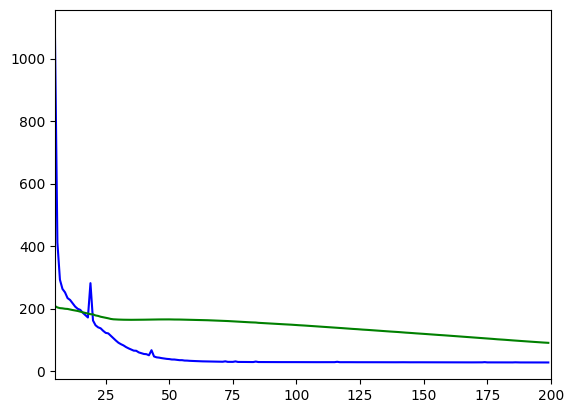

In [28]:
start = 5
loss_plot(model.train_loss[start:], model.valid_loss[start:], x_axis=[start, len(model.valid_loss)])

In [24]:
criterion = nn.MSELoss()
test_loss = []
with torch.no_grad():
    true_y, pred_y = model.predict(test_loader)                
    true_y = torch.FloatTensor(true_y).unsqueeze(dim=1)
    pred_y = torch.FloatTensor(pred_y)
    loss = criterion(pred_y, true_y)
    test_loss.append(loss.item())
    print(loss.item())

31.762788772583008


## Visualization

### CNN Filter visualization

In [29]:
fm = model.squeeze_conv.weight[0]
np_fmap = fm.cpu().detach().numpy()
# 각 채널을 시각화하기 위해 2D 이미지로 변환
channel_images = [np_fmap[channel_idx, :, :] for channel_idx in range(np_fmap.shape[0])]

# 채널 이미지 시각화
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(100, 100))
for idx, ax in enumerate(axes.flat):
    ax.imshow(channel_images[idx], cmap='gray')
    ax.axis('off')
plt.show()

In [30]:
import numpy as np
import os
def add_padding(img, padding=1):
    w = img.shape[0] + padding * 2
    h = img.shape[1] + padding * 2
    expanded_img = np.zeros(w*h).reshape(w, h)
    
    # 가장자리 제외한 부분
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            expanded_img[i+padding][j+padding] = img[i][j]
    # 가장자리 상하
    for i in range(padding):
        expanded_img[i] = expanded_img[padding]
        expanded_img[w-i-1] = expanded_img[w-padding-1]
    # 가장자리 좌우
    for i in range(w):
        for j in range(padding):
            expanded_img[i][j] = expanded_img[i][padding]
            expanded_img[i][h-j-1] = expanded_img[i][h-padding-1]
    
    return expanded_img
    
# kernel size is odd
def cross_correlation_1d ( img , kernel ) :
    w_i, h_i = img.shape
    
    if len(kernel.shape) == 1:
        kernel = np.array([kernel])
        w_k, h_k = kernel.shape
    else :
        w_k, h_k = kernel.shape
        
    filtered_img = []
    if h_k == 1: # vertical
        padding = w_k // 2
        ex_img = add_padding(img, padding)
        w_i, h_i = ex_img.shape
        w_step = w_i - w_k + 1
        h_step = h_i - 2*padding
        for i in range(w_step):
            img_row = []
            for j in range(h_step):
                y = padding + j
                fit_img = ex_img[i:i+w_k, y:y+1]
                co_sum = 0
                for k in range(w_k):
                    row_sum = np.dot(fit_img[k], kernel[k])
                    co_sum += row_sum
                img_row.append(round(co_sum))
            filtered_img.append(img_row)
    elif w_k == 1: # horizontal
        padding = h_k // 2
        ex_img = add_padding(img, padding)
        w_i, h_i = ex_img.shape
        h_step = h_i - h_k + 1
        w_step = w_i - 2*padding
        for i in range(w_step):
            img_row = []
            for j in range(h_step):
                x = padding + i
                fit_img = ex_img[x:x+1, j:j+h_k ]
                co_sum = 0
                for k in range(w_k):
                    row_sum = np.dot(fit_img[k], kernel[k])
                    co_sum += row_sum
                img_row.append(co_sum)
            filtered_img.append(img_row)
    filtered_img = np.array(filtered_img)
    return filtered_img

def cross_correlation_2d ( img , kernel ) :
    
    w_k, h_k = kernel.shape
    ex_img = add_padding(img, w_k // 2)
    w_i, h_i = ex_img.shape
    w_step = w_i - w_k + 1
    h_step = h_i - h_k + 1
     
    filtered_img = []
    for i in range(w_step):
        img_row = []
        for j in range(h_step):
            fit_img = ex_img[i:i+w_k, j:j+h_k]
            co_sum = 0
            for k in range(w_k):
                row_sum = np.dot(fit_img[k], kernel[k])
                co_sum += row_sum
            img_row.append(co_sum)
            
        filtered_img.append(img_row)
    filtered_img = np.array(filtered_img)
    return filtered_img

In [31]:
import cv2
image = cv2.imread( work_dir+'medium_15287/{}.jpg'.format("zbsW6FeS0n0") ,cv2.IMREAD_GRAYSCALE)
filtered_img = cross_correlation_2d(image, channel_images[0])

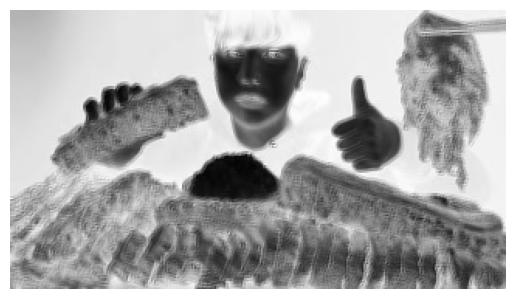

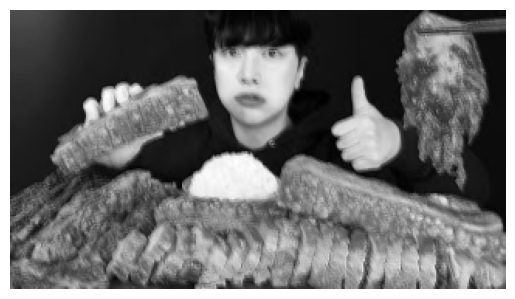

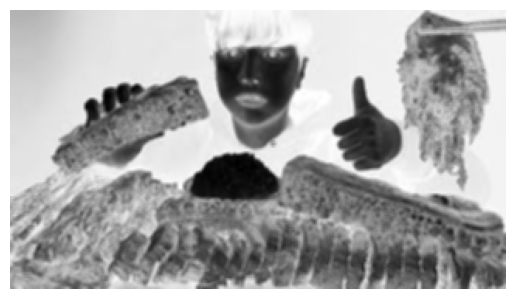

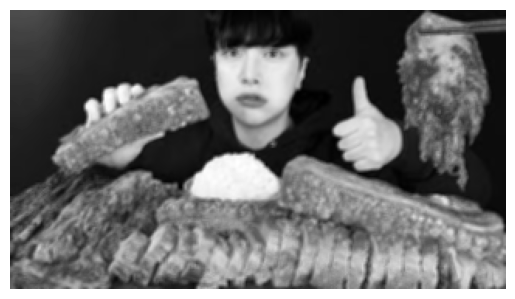

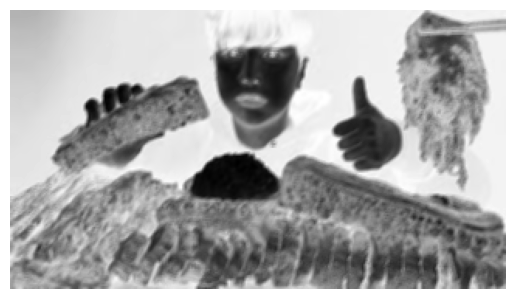

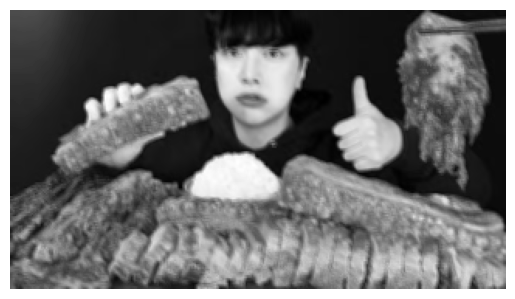

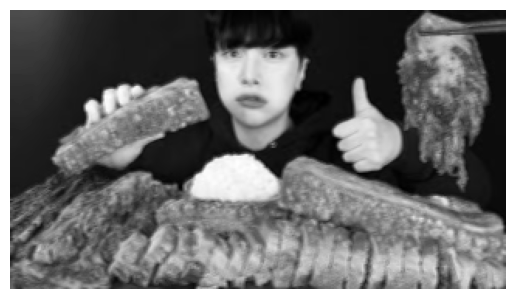

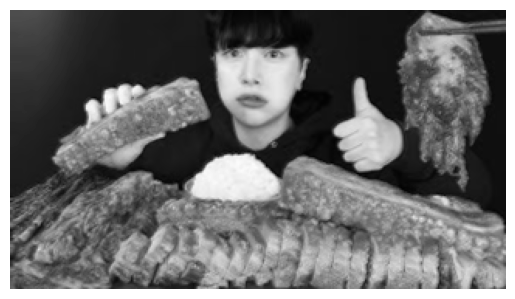

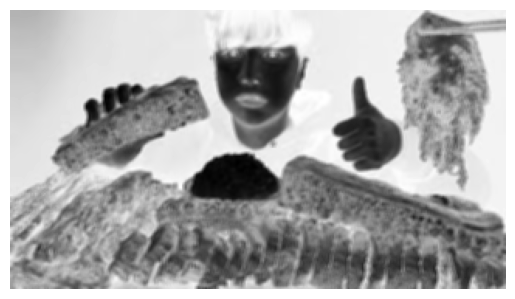

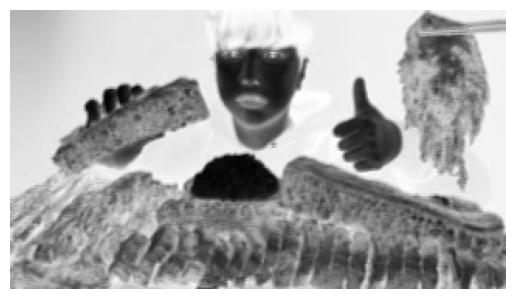

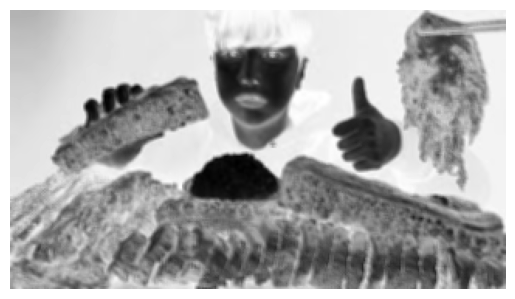

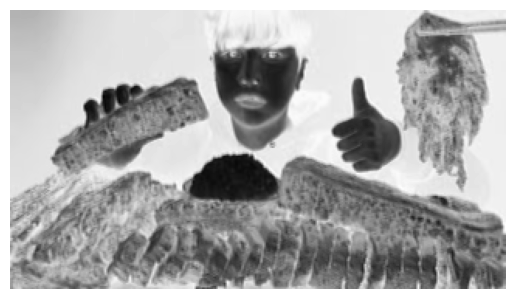

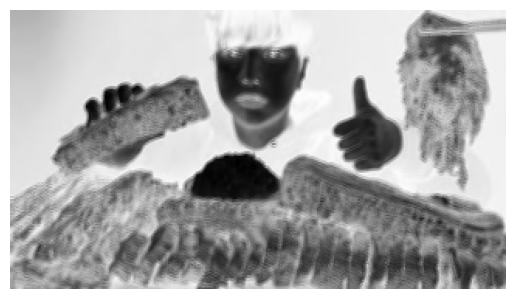

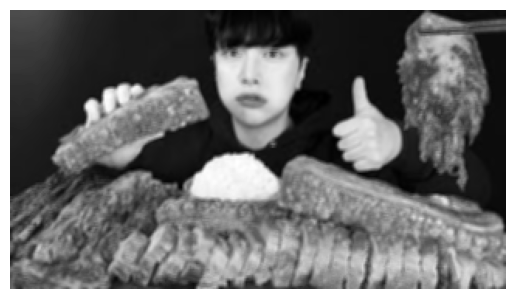

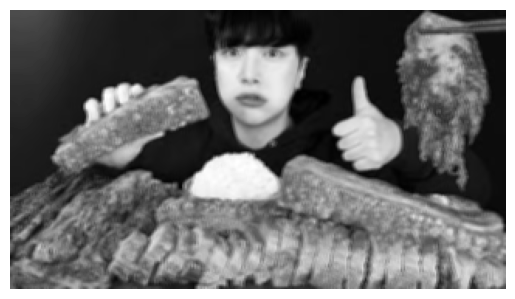

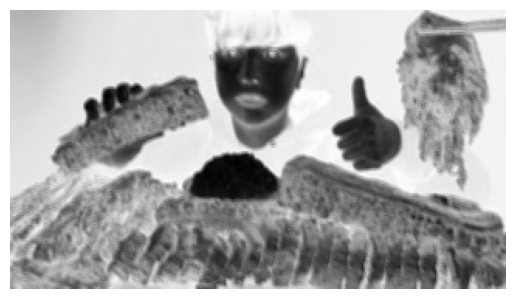

In [32]:
for i in range(320):
  filtered_img = cross_correlation_2d(image, channel_images[i])
  if i % 20 == 0:
    plt.imshow(filtered_img, cmap='gray')  # 흑백 이미지로 표시 (cmap='gray' 옵션)
    plt.axis('off')  # 축 제거
    plt.show()

### MLP hidden weight visualization

In [6]:
# trained model
trained_model = "/kaggle/input/bestmodel0515/epoch200_train19.1116_valid44.6093.pt"
with open(trained_model, "rb") as f:
   state_dict = torch.load(f)
   model.load_state_dict(state_dict)

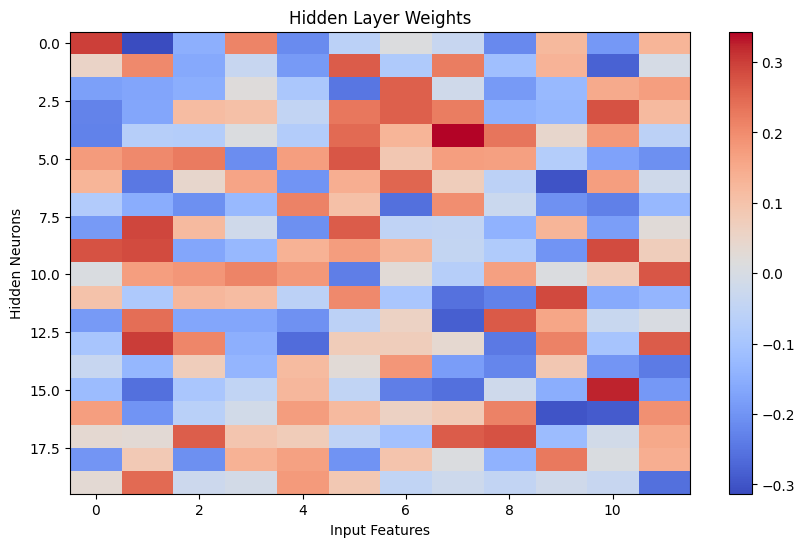

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# MLP 모델에서 hidden layer의 가중치 추출
hidden_weights = model.final_concat_fc1.weight.data.cpu().numpy()

# 가중치를 2차원 그리드 형태로 변환
hidden_weights_grid = hidden_weights.reshape(model.final_concat_hidden, model.img_title_concat_out+2)

# 가중치 시각화
plt.figure(figsize=(10, 6))
plt.imshow(hidden_weights_grid, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Weights")
plt.xlabel("Input Features")
plt.ylabel("Hidden Neurons")
plt.show()

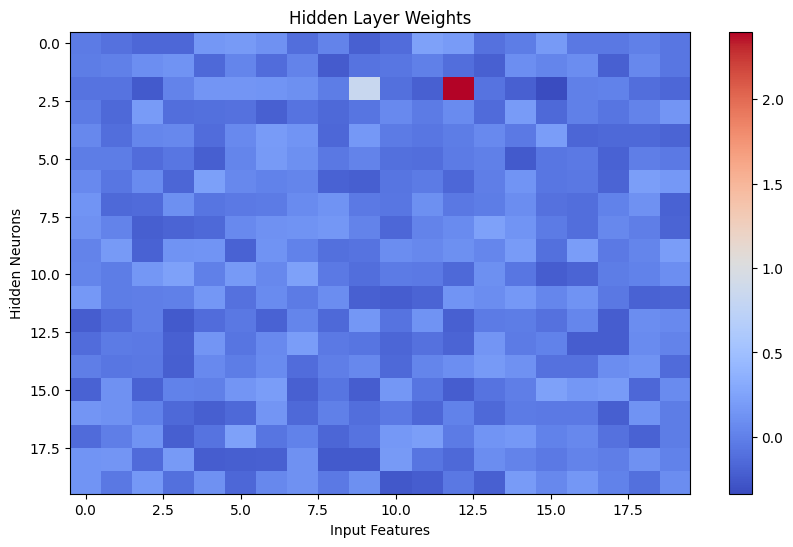

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# MLP 모델에서 hidden layer의 가중치 추출
hidden_weights = model.final_concat_fc_hidden.weight.data.cpu().numpy()

# 가중치를 2차원 그리드 형태로 변환
hidden_weights_grid = hidden_weights.reshape(model.final_concat_hidden, model.final_concat_hidden)

# 가중치 시각화
plt.figure(figsize=(10, 6))
plt.imshow(hidden_weights_grid, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Weights")
plt.xlabel("Input Features")
plt.ylabel("Hidden Neurons")
plt.show()

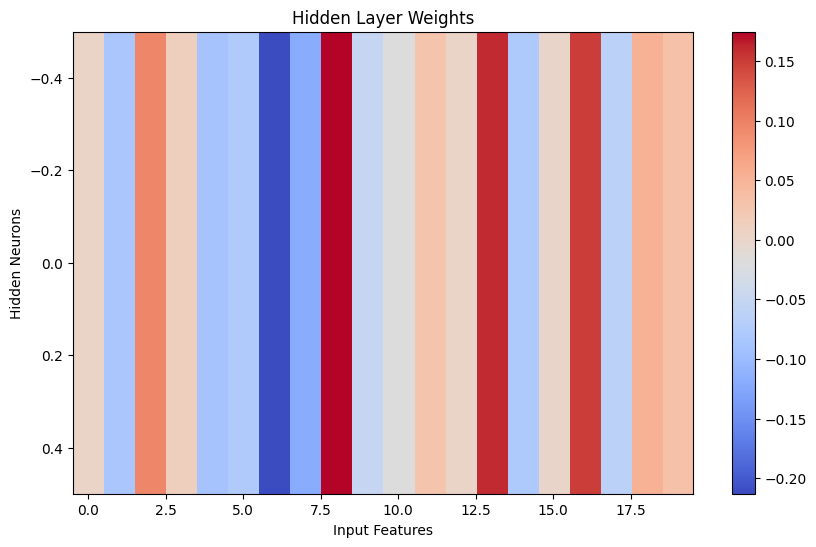

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# MLP 모델에서 hidden layer의 가중치 추출
hidden_weights = model.final_concat_fc2.weight.data.cpu().numpy()

# 가중치를 2차원 그리드 형태로 변환
hidden_weights_grid = hidden_weights.reshape(model.final_concat_out, model.final_concat_hidden)

# 가중치 시각화
plt.figure(figsize=(10, 6))
plt.imshow(hidden_weights_grid, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Weights")
plt.xlabel("Input Features")
plt.ylabel("Hidden Neurons")
plt.show()

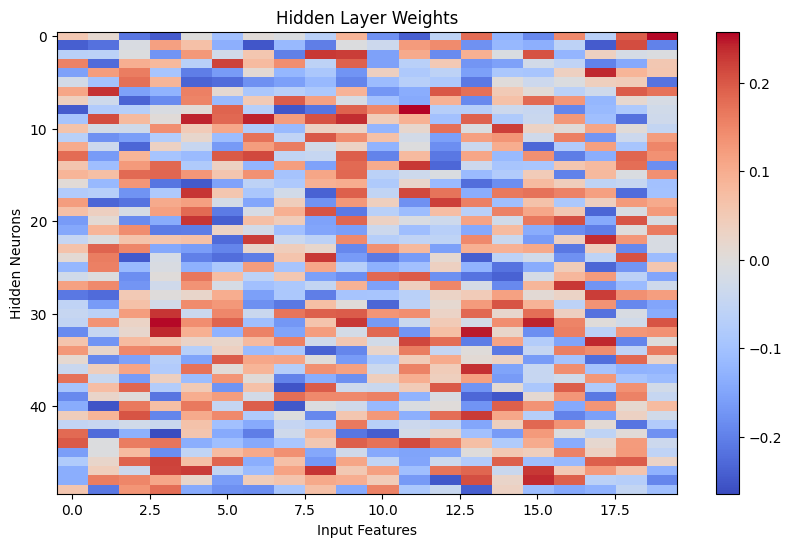

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# MLP 모델에서 hidden layer의 가중치 추출
hidden_weights = model.img_title_concat_fc1.weight.data.cpu().numpy()

# 가중치를 2차원 그리드 형태로 변환
hidden_weights_grid = hidden_weights.reshape(model.img_title_concat_hidden, model.bottle_nect_out_channel+model.title_channel)

# 가중치 시각화
plt.figure(figsize=(10, 6))
plt.imshow(hidden_weights_grid, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Weights")
plt.xlabel("Input Features")
plt.ylabel("Hidden Neurons")
plt.show()

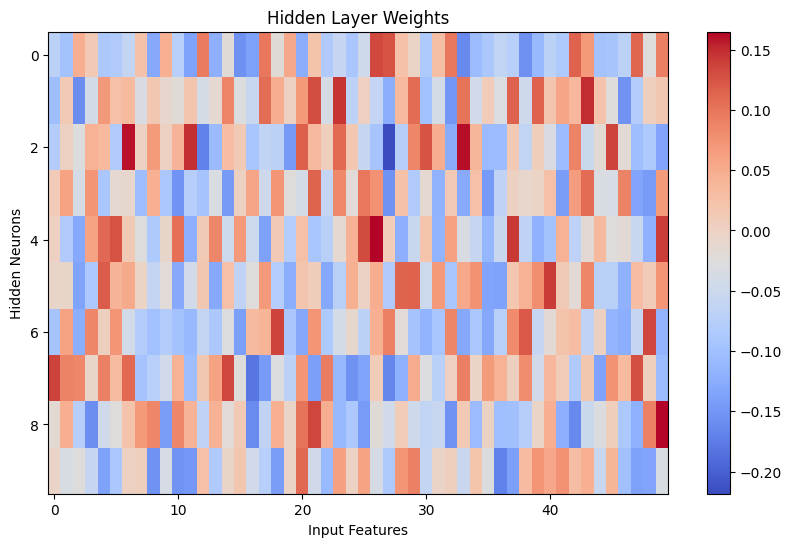

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# MLP 모델에서 hidden layer의 가중치 추출
hidden_weights = model.img_title_concat_fc2.weight.data.cpu().numpy()

# 가중치를 2차원 그리드 형태로 변환
hidden_weights_grid = hidden_weights.reshape(model.img_title_concat_out, model.img_title_concat_hidden)

# 가중치 시각화
plt.figure(figsize=(10, 6))
plt.imshow(hidden_weights_grid, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Hidden Layer Weights")
plt.xlabel("Input Features")
plt.ylabel("Hidden Neurons")
plt.show()